#                                          Analysing Order Rejection by Customers

### Import Libraries

In [256]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

import shap

from scipy import stats
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler,OrdinalEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV

from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,precision_score,recall_score,f1_score,roc_auc_score,classification_report,plot_confusion_matrix,plot_roc_curve,plot_precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC


plt.rcParams['figure.figsize'] = [15,8]

In [257]:
# Rejected --1, Not Rejected -- 0

### Import dataset

In [384]:
amazon=pd.read_csv("Amazon Sale Report.csv")
amazon.head(2)

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN


In [385]:
# make copy of origin dataset and used copied data for further analysis

df=amazon.copy()

### Check size and data types

In [386]:
df.shape

(128975, 24)

**Interpretation:** The data has 128975 observations and 24 variables.

In [387]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  int64  
 1   Order ID            128975 non-null  object 
 2   Date                128975 non-null  object 
 3   Status              128975 non-null  object 
 4   Fulfilment          128975 non-null  object 
 5   Sales Channel       128975 non-null  object 
 6   ship-service-level  128975 non-null  object 
 7   Style               128975 non-null  object 
 8   SKU                 128975 non-null  object 
 9   Category            128975 non-null  object 
 10  Size                128975 non-null  object 
 11  ASIN                128975 non-null  object 
 12  Courier Status      122103 non-null  object 
 13  Qty                 128975 non-null  int64  
 14  currency            121180 non-null  object 
 15  Amount              121180 non-nul

**Interpretation:** There are 19 object,2 int, 2 float and 1 boolean.

The variables `index`, `Qty`, `Amount`, `ship-postal-code` are numerical.

`B2B` is boolen.

Rest all are objects.

From the above output, we see that the data type of `Date` is 'object' and `ship-postal-code` is 'float'.

But according to the data definition, `Date` is a date variable, which is wrongly interpreted as 'object', so we will convert these variables data type to 'date'
and `ship-postal-code` is a object variable, which is wrongly interpreted as 'float', so we will convert it to 'object'.

In [388]:
# change the datatype of ship-postal-code and date  to object and date

df["ship-postal-code"] = df["ship-postal-code"].astype(object)
df['Date'] = pd.to_datetime(df['Date'])

### Drop duplicates

In [389]:
# check for duplicates

df = df.drop_duplicates()

### Drop columns based on domain understanding

In [390]:
# drop unnessary columns

df.drop(columns=["index","Unnamed: 22","ship-country","currency","fulfilled-by","ship-city","ship-postal-code",
                 "Style","ASIN","SKU","Date","promotion-ids","Courier Status"],inplace=True)

**Interpretation:** The above columns are redundant for further analysis. Thus, we drop the column.

### 5-point summary for numeric and categorical columns

In [391]:
#describe

df.describe(include='object')

,Order ID,Status,Fulfilment,Sales Channel,ship-service-level,Category,Size,ship-state
count,128975,128975,128975,128975,128975,128975,128975,128942
unique,120378,13,2,2,2,9,11,69
top,171-5057375-2831560,Shipped,Amazon,Amazon.in,Expedited,Set,M,MAHARASHTRA
freq,12,77804,89698,128851,88615,50284,22711,22260


**Interpretation:** We can find the below details for all the categorical columns:
- the total count of each categorical column
- unique values in each categorical column
- the top category and it's frequency

In [392]:
df.describe(include=np.number)

,Qty,Amount
count,128975.000000,121180.000000
mean,0.904431,648.561465
std,0.313354,281.211687
min,0.000000,0.000000
25%,1.000000,449.000000
50%,1.000000,605.000000
75%,1.000000,788.000000
max,15.000000,5584.000000


**Interpretation:** We can find the below details for all the numeric columns:
- minimum value
- maximum value
- median value
- Q1 and Q3 values
- average value

### Null value treatment

In [393]:
# null values

df.isna().sum()

Order ID                 0
Status                   0
Fulfilment               0
Sales Channel            0
ship-service-level       0
Category                 0
Size                     0
Qty                      0
Amount                7795
ship-state              33
B2B                      0
dtype: int64

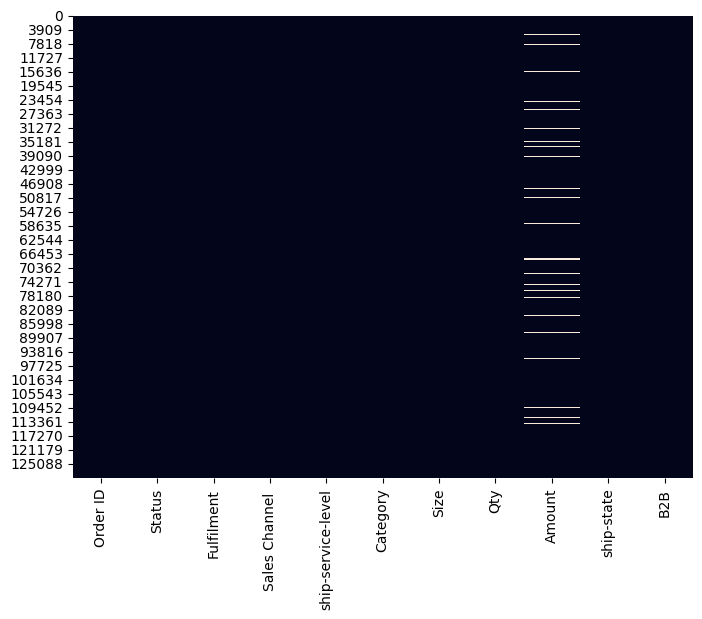

In [394]:
plt.figure(figsize=(8,6))
sns.heatmap(df.isna(),cbar=False)
plt.show()

**Interpretation:** The plot shows that there are Null values present in `Courier Status`,`Amount`,`ship-state` and `promotion-ids`


In [269]:
# percentage oif null values

((df.isna().sum()/df.isna().count())*100).sort_values(ascending=False)

Amount                6.043807
ship-state            0.025586
Order ID              0.000000
Status                0.000000
Fulfilment            0.000000
Sales Channel         0.000000
ship-service-level    0.000000
Category              0.000000
Size                  0.000000
Qty                   0.000000
B2B                   0.000000
dtype: float64

In [270]:
# since all the null values are less than 6% we can impute mean for numeric and mode for categorical data

df['ship-state']=df['ship-state'].fillna(df['ship-state'].mode()[0])
df['Amount']=df['Amount'].fillna(0.0)

In [271]:
# few records of Amount column is 0 but the status is not rejected, hence only for not rejected records fill the 0 
# with meandian of that category type.
gp=df.groupby("Category")["Amount"].median()
a=gp.index
b=gp.values
d = dict(zip(a,b))
print(d)

{'Blouse': 518.0, 'Bottom': 342.86, 'Dupatta': 305.0, 'Ethnic Dress': 799.0, 'Saree': 790.0, 'Set': 759.0, 'Top': 518.0, 'Western Dress': 744.0, 'kurta': 432.0}


In [272]:
df[df["Amount"]==0.0].shape

(10138, 11)

In [273]:
for index, row in df.iterrows():
    if row["Status"] == "Not Rejected":
        if row["Amount"] == 0.0:
            for key, value in d.items():
                if row['Category'] in key:
                    df.at[index, "Amount"] = value

In [274]:
df[df["Amount"]==0.0].shape

(10138, 11)

In [275]:
# only rejected columns are left as 0 amount

df[(df["Status"]=='Rejected') & (df["Amount"]==0.0)].shape

(0, 11)

In [276]:
# null values treated

df.isna().sum()

Order ID              0
Status                0
Fulfilment            0
Sales Channel         0
ship-service-level    0
Category              0
Size                  0
Qty                   0
Amount                0
ship-state            0
B2B                   0
dtype: int64

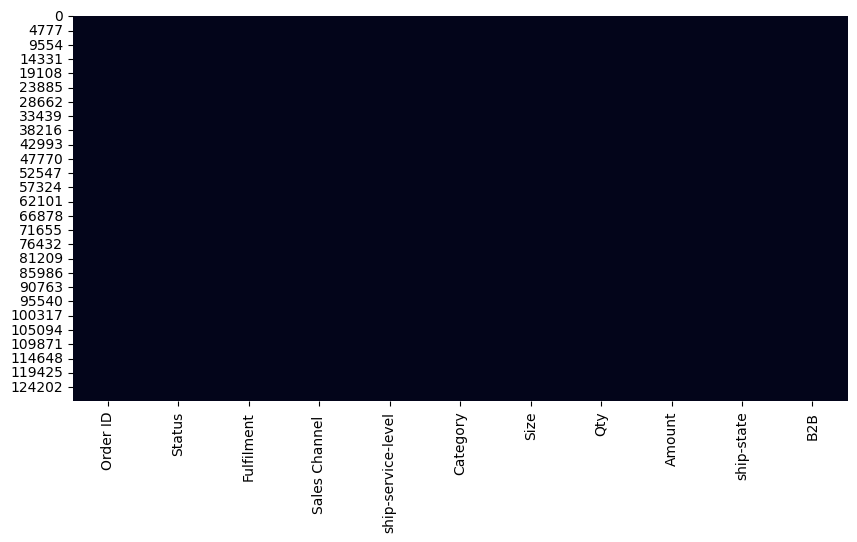

In [277]:
plt.figure(figsize=(10,5))
sns.heatmap(df.isna(),cbar=False)
plt.show()

*All the null values are imputed.*

### Data Cleaning

In [278]:
# to remove (' ') from the column name

cols=df.columns
cols_l=[i.strip() for i in cols]

df.columns = cols_l
df.columns

Index(['Order ID', 'Status', 'Fulfilment', 'Sales Channel',
       'ship-service-level', 'Category', 'Size', 'Qty', 'Amount', 'ship-state',
       'B2B'],
      dtype='object')

In [279]:
# renaming "Sales Channel " by removing the space

df.rename(columns=({"ship-service-level":"Ship Service Level"}),inplace=True)
df.rename(columns=({"ship-state":"Ship State"}),inplace=True)
df.columns

Index(['Order ID', 'Status', 'Fulfilment', 'Sales Channel',
       'Ship Service Level', 'Category', 'Size', 'Qty', 'Amount', 'Ship State',
       'B2B'],
      dtype='object')

In [280]:
# in state column, many states are spelled wronlgly and few are capital and few are small letters

df["Ship State"].unique()

array(['MAHARASHTRA', 'KARNATAKA', 'PUDUCHERRY', 'TAMIL NADU',
       'UTTAR PRADESH', 'CHANDIGARH', 'TELANGANA', 'ANDHRA PRADESH',
       'RAJASTHAN', 'DELHI', 'HARYANA', 'ASSAM', 'JHARKHAND',
       'CHHATTISGARH', 'ODISHA', 'KERALA', 'MADHYA PRADESH',
       'WEST BENGAL', 'NAGALAND', 'Gujarat', 'UTTARAKHAND', 'BIHAR',
       'JAMMU & KASHMIR', 'PUNJAB', 'HIMACHAL PRADESH',
       'ARUNACHAL PRADESH', 'MANIPUR', 'Goa', 'MEGHALAYA', 'GOA',
       'TRIPURA', 'LADAKH', 'DADRA AND NAGAR', 'SIKKIM', 'Delhi',
       'ANDAMAN & NICOBAR ', 'Punjab', 'Rajshthan', 'Manipur',
       'rajasthan', 'Odisha', 'NL', 'Bihar', 'MIZORAM', 'punjab',
       'New Delhi', 'Rajasthan', 'Punjab/Mohali/Zirakpur', 'Puducherry',
       'delhi', 'RJ', 'Chandigarh', 'orissa', 'LAKSHADWEEP', 'goa', 'PB',
       'APO', 'Arunachal Pradesh', 'AR', 'Pondicherry', 'Sikkim',
       'Arunachal pradesh', 'Nagaland', 'bihar', 'Mizoram', 'rajsthan',
       'Orissa', 'Rajsthan', 'Meghalaya'], dtype=object)

In [281]:
df["Ship State"] = df["Ship State"].str.upper()
df["Ship State"].replace({"PUDUCHERRY":"PONDICHERRY","RAJSHTHAN":"RAJASTHAN","RAJSTHAN":"RAJASTHAN","RJ":"RAJASTHAN",
                         "PB":"PUNJAB","PUNJAB/MOHALI/ZIRAKPUR":"PUNJAB","ORISSA":"ODISHA","DELHI":"NEW DELHI",
                         "NL":"UNKNOWN","APO":"UNKNOWN","AR":"UNKNOWN"}, inplace = True)


In [282]:
df["Ship State"].unique()

array(['MAHARASHTRA', 'KARNATAKA', 'PONDICHERRY', 'TAMIL NADU',
       'UTTAR PRADESH', 'CHANDIGARH', 'TELANGANA', 'ANDHRA PRADESH',
       'RAJASTHAN', 'NEW DELHI', 'HARYANA', 'ASSAM', 'JHARKHAND',
       'CHHATTISGARH', 'ODISHA', 'KERALA', 'MADHYA PRADESH',
       'WEST BENGAL', 'NAGALAND', 'GUJARAT', 'UTTARAKHAND', 'BIHAR',
       'JAMMU & KASHMIR', 'PUNJAB', 'HIMACHAL PRADESH',
       'ARUNACHAL PRADESH', 'MANIPUR', 'GOA', 'MEGHALAYA', 'TRIPURA',
       'LADAKH', 'DADRA AND NAGAR', 'SIKKIM', 'ANDAMAN & NICOBAR ',
       'UNKNOWN', 'MIZORAM', 'LAKSHADWEEP'], dtype=object)

**Analyse orderid Column**

In [283]:
# dataframe of repeated orderid(s) - all rows
orderid_repeat_rows = df[df["Order ID"].duplicated(keep = False)]

# count the unique repeated orderid(s)
unique_orderid_repeat_count = orderid_repeat_rows["Order ID"].nunique()

# count the total number of rows in the dataset occupied by repeated orders
orderid_repeat_rows_count = len(orderid_repeat_rows)

# count the number of rows in the dataset occuppied by nonrepeat_orderids
orderid_nonrepeat_rows = df[df["Order ID"].duplicated(keep = False) == False]
orderid_nonrepeat_rows_count = len(orderid_nonrepeat_rows)
 
print(f"1. Number of unique orderid with multiple products per orderid purchased: {unique_orderid_repeat_count}\n"
         f"2. Total number of rows of these orderid(s) with multiple products: {orderid_repeat_rows_count}\n"
          f"3. Number of unique orderid with single product per orderid purchased: {orderid_nonrepeat_rows_count}"
         )

1. Number of unique orderid with multiple products per orderid purchased: 6846
2. Total number of rows of these orderid(s) with multiple products: 15443
3. Number of unique orderid with single product per orderid purchased: 113532


In [284]:
orderid_repeat_rows = df[df["Order ID"].duplicated(keep = False)]

In [285]:
orderid_repeat_rows.reset_index(inplace=True)

In [286]:
df.reset_index(inplace=True)

In [287]:
df['Product Proportions'] = df['index'].apply(lambda x: 'Multiple Products' if x in orderid_repeat_rows['index'] else 'Single Product')

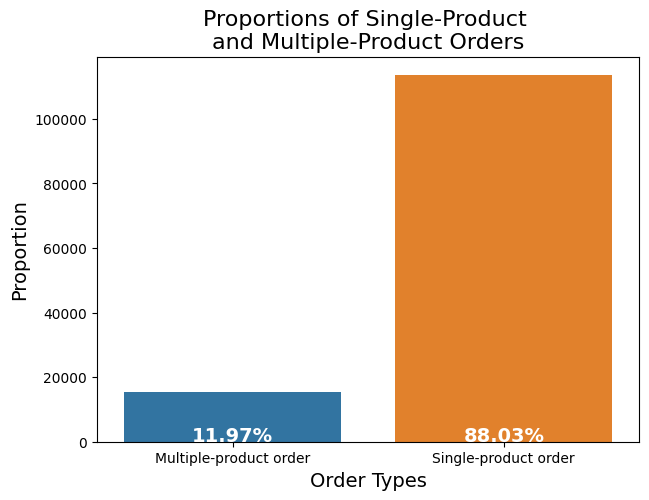

In [288]:
fig,ax = plt.subplots(figsize = (7,5))
sns.countplot(df['Product Proportions'])
plt.title("Proportions of Single-Product \nand Multiple-Product Orders", fontsize = 16)
plt.ylabel("Proportion", fontsize = 14)
plt.xlabel("Order Types", fontsize = 14)
plt.xticks(ticks=[0,1],labels=['Multiple-product order','Single-product order'])

plot_dataseries = round(df["Product Proportions"].value_counts(normalize = True)*100,2).sort_values(ascending=True)
data_label = plot_dataseries.astype(str).str.cat(np.full((2,),"%"), sep = "")

for x,y in enumerate(plot_dataseries):
    plt.text(x,y,data_label[x],color = "white",
             fontweight = 700,fontsize = 14, horizontalalignment = "center")
plt.show()

In [289]:
df.drop('index', axis=1, inplace=True)

**Inference:**
- We see that 88.03% (almost 90%)of the data are from orders with single-product order.
- We are now interested in the majority and, therefore, drop the multiple-product orders.
- And, we focus our analysis on the single-product orders for prediction/classification

**Actions:**
- We drop the orderid(s) multiple-product orders.
- We further drop "orderid" column which is plainly not required (redundant) now.

In [290]:
df = df[df["Order ID"].duplicated(keep = False) == False]

df.drop("Order ID", axis = 1, inplace = True)

### Creating target variable by modifying Status column

In [291]:
df["Status"].unique()

array(['Cancelled', 'Shipped - Delivered to Buyer', 'Shipped',
       'Shipped - Returned to Seller', 'Shipped - Rejected by Buyer',
       'Shipped - Lost in Transit', 'Shipped - Out for Delivery',
       'Shipped - Returning to Seller', 'Shipped - Picked Up', 'Pending',
       'Pending - Waiting for Pick Up', 'Shipped - Damaged', 'Shipping'],
      dtype=object)

In [292]:
df.head(3)

,Status,Fulfilment,Sales Channel,Ship Service Level,Category,Size,Qty,Amount,Ship State,B2B,Product Proportions
0,Cancelled,Merchant,Amazon.in,Standard,Set,S,0,647.62,MAHARASHTRA,False,Multiple Products
1,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,kurta,3XL,1,406.00,KARNATAKA,False,Multiple Products
2,Shipped,Amazon,Amazon.in,Expedited,kurta,XL,1,329.00,MAHARASHTRA,True,Multiple Products


In [293]:
# drop the rows with unsure rejection status
known_value = ["Cancelled", 'Shipped - Returned to Seller','Shipped - Rejected by Buyer',
            'Shipped - Returning to Seller','Shipped - Delivered to Buyer']
df = df[df["Status"].isin(known_value)]   

# create a col "rejected" where value 1 means rejected and 0 means not-rejected" 
rejected = ["Cancelled", 'Shipped - Returned to Seller','Shipped - Rejected by Buyer',
            'Shipped - Returning to Seller']
df["Status"] = df["Status"].isin(rejected).astype(int)    # change the dtype to "int" 

In [294]:
df.reset_index(inplace=True)

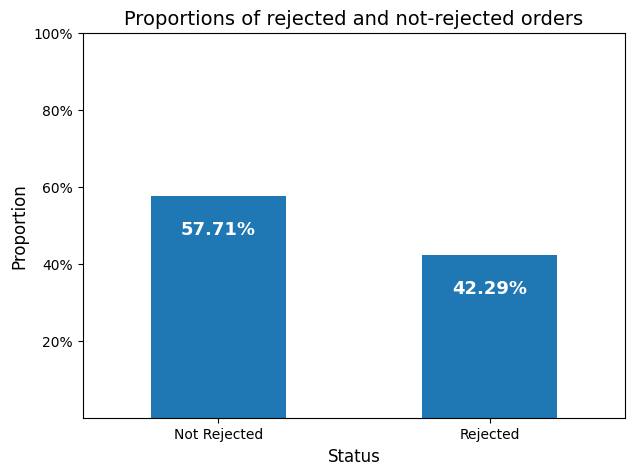

In [295]:
fig,ax = plt.subplots(figsize = (7,5))

plot_dataseries = round(df["Status"].value_counts(normalize = True)*100,2)

plot_dataseries.plot(kind = "bar",ax =ax)
plt.title("Proportions of rejected and not-rejected orders", fontsize = 14)
plt.ylabel("Proportion", fontsize = 12)
plt.xlabel("Status", fontsize = 12)
plt.xticks(ticks = range(len(plot_dataseries)),
           labels = ["Not Rejected", "Rejected"], rotation = "horizontal")
plt.yticks(ticks = [20,40,60,80,100], labels = ["20%","40%","60%","80%","100%"])

data_label = plot_dataseries.astype(str).str.cat(np.full((2,),"%"), sep = "")

data_count = df["Status"].value_counts()

for x,y in enumerate(plot_dataseries):
    plt.text(x,y-10,data_label[x],color = "white",
             fontweight = 700,fontsize = 13, horizontalalignment = "center")
    
plt.show()

**Inference:**
- Dataset seems to be having unbalanced class distribution aprox. 58% as not-rejected and 42% as rejected.

**Action:**
- We shall keep it as it is. But, we will resample later during training.

## Checking for significant features

**1) Analysing feature "qty": Quantity per Order**

In [296]:
qty_prop=pd.DataFrame({'Count':df['Qty'].value_counts(),
           'Proportion(%)':round(df['Qty'].value_counts(normalize=True)*100,2)})
qty_prop

,Count,Proportion(%)
1,31518,73.30
0,11376,26.46
2,90,0.21
3,8,0.02
4,3,0.01
5,2,0.00


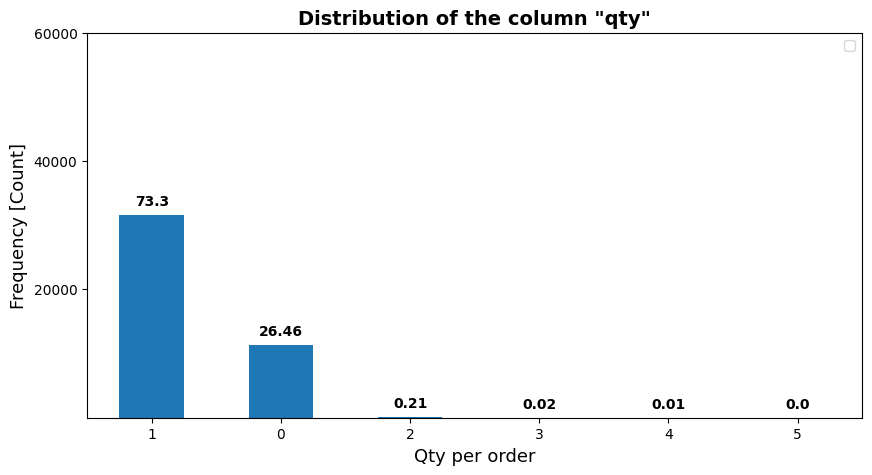

In [297]:
fig, ax = plt.subplots(figsize = (10,5))
qty_prop.plot(kind = "bar",y = "Count",ax = ax)
plt.xlabel("Qty per order", fontsize = 13)
plt.ylabel("Frequency [Count]",fontsize = 13)
plt.yticks(ticks = range(20000,60001,20000))
plt.title('Distribution of the column "qty"', fontsize = 14,fontweight = 550)
plt.xticks(rotation = "horizontal")
plt.legend("")
for x,y in enumerate(qty_prop["Count"]):
    qty_value = qty_prop.index[x]
    plt.text(x,y+1500,qty_prop["Proportion(%)"].loc[qty_value],
            horizontalalignment = "center",fontweight = 700)

plt.show()

**Inference:**

- 0th order number is assumed to be "NaN" as  Qty per order cannot be "0"
- Feature "qty" is highly skewed (when assuming it as *continuous variable*), or
- It's highly imbalanced (when assuming it as *categorical variable*)
- It's logical to assume the value "0" as "NaN" (Null) because an order purchased cannot have quantity "0"
- More than 99% of datapoints have value "1" or "NaN" so it may not add much information in the analysis.

**Actions:**

- Therefore, we drop feature "qty".

In [298]:
df.drop("Qty", axis = "columns", inplace = True)

**2) Analyse the feature "fulfilment"**

In [299]:
df_cat = df["Fulfilment"].value_counts().to_frame()
df_cat["proportion"] = round(df["Fulfilment"].value_counts(normalize = True)*100,2)
df_cat["proportion"] = df_cat["proportion"].astype(str).str.cat(np.full((2,),"%"))
df_cat = (df_cat.reset_index()
          .rename(columns = {"Fulfilment":"Count","index":"Fulfilment type"}))
df_cat

,Fulfilment type,Count,proportion
0,Merchant,32703,76.06%
1,Amazon,10294,23.94%


**Inference:** 

- Although the distribution is imbalanced it still looks good for the purpose of this analysis as the frequency (counts) values are not small.

**Actions:**  
- No action

**3) Analyse the feature "saleschannel"**

In [300]:
df_cat = df["Sales Channel"].value_counts().to_frame()
df_cat["proportion"] = round(df["Sales Channel"].value_counts(normalize = True)*100,4)
df_cat["proportion"] = df_cat["proportion"].astype(str).str.cat(np.full((2,),"%"))
df_cat = (df_cat.reset_index()
          .rename(columns = {"Sales Channel":"count","index":"Sales Channel Type"}))
df_cat

,Sales Channel Type,count,proportion
0,Amazon.in,42996,99.9977%
1,Non-Amazon,1,0.0023%


**Inference:**

- The distribution is extremely imbalanced and the frequency (counts) value of "Non-Amazon" is just "1" and thus will not add value (information) to our analysis.

**Actions:**

- Drop the feature "saleschannel"

In [301]:
df.drop("Sales Channel", axis = "columns", inplace = True)

**3) Analyse the feature "shipservicelevel"**

In [302]:
df_cat = df["Ship Service Level"].value_counts().to_frame()
df_cat["proportion"] = round(df["Ship Service Level"].value_counts(normalize = True)*100,2)
df_cat["proportion"] = df_cat["proportion"].astype(str).str.cat(np.full((2,),"%"))
df_cat = (df_cat.reset_index()
          .rename(columns = {"Ship Service Level":"count","index":"Ship Service Level Type"}))
df_cat

,Ship Service Level Type,count,proportion
0,Standard,32749,76.17%
1,Expedited,10248,23.83%


**Inference:**

- Although the distribution is imbalanced it still looks good for the purpose of this analysis as the frequency (counts) values are not small.

**Actions:**

- No action

**4) Analyse the feature "category"**

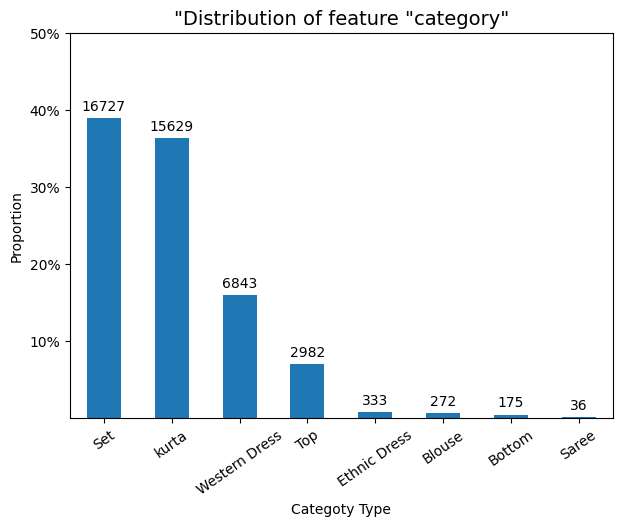

In [303]:
fig,ax = plt.subplots(figsize = (7,5))
df_cat = df["Category"].value_counts().to_frame()
df_cat["proportion"] = round(df["Category"].value_counts(normalize = True)*100,2)
df_cat["proportion_label"] = df_cat["proportion"].astype(str).str.cat(np.full((len(df_cat),),"%"))
df_cat = (df_cat.reset_index()
          .rename(columns = {"Category":"count","index":"Category Type"}))

df_cat.plot(
    kind = "bar", x = "Category Type",y = "proportion",
    legend = "", ax = ax
)
plt.xlabel("Categoty Type")
plt.ylabel("Proportion")
plt.title('"Distribution of feature "category"', fontsize = 14)
plt.xticks(rotation = 35)
plt.yticks(ticks = range(10,51,10) ,labels =["10%","20%","30%","40%","50%"])

for x,y in enumerate(df_cat["count"]):
    plt.text(x,1+df_cat["proportion"][x],y,
             fontsize = 10, horizontalalignment = "center")
plt.show()

**Inference:**

- Although the distribution is imbalanced it still looks good for the purpose of this analysis as the frequency (counts) values are not small.

**Actions:**

- No action

**5) Analyse the feature "b2b"**

In [304]:
df_cat = df["B2B"].value_counts().to_frame()
df_cat["proportion"] = round(df["B2B"].value_counts(normalize = True)*100,2)
df_cat["proportion"] = df_cat["proportion"].astype(str).str.cat(np.full((2,),"%"))
df_cat = (df_cat.reset_index()
          .rename(columns = {"B2B":"count","index":"B2B Type"}))
df_cat

,B2B Type,count,proportion
0,False,42744,99.41%
1,True,253,0.59%


**Inference:**
- Although the distribution is imbalanced it still looks ok for the purpose of this analysis as the frequency (counts) values are not small.

**Actions:**
- Change the data type to categorical/object

In [305]:
df["B2B"] = df["B2B"].astype(object)

**6) Analyse the feature "Ship State "**

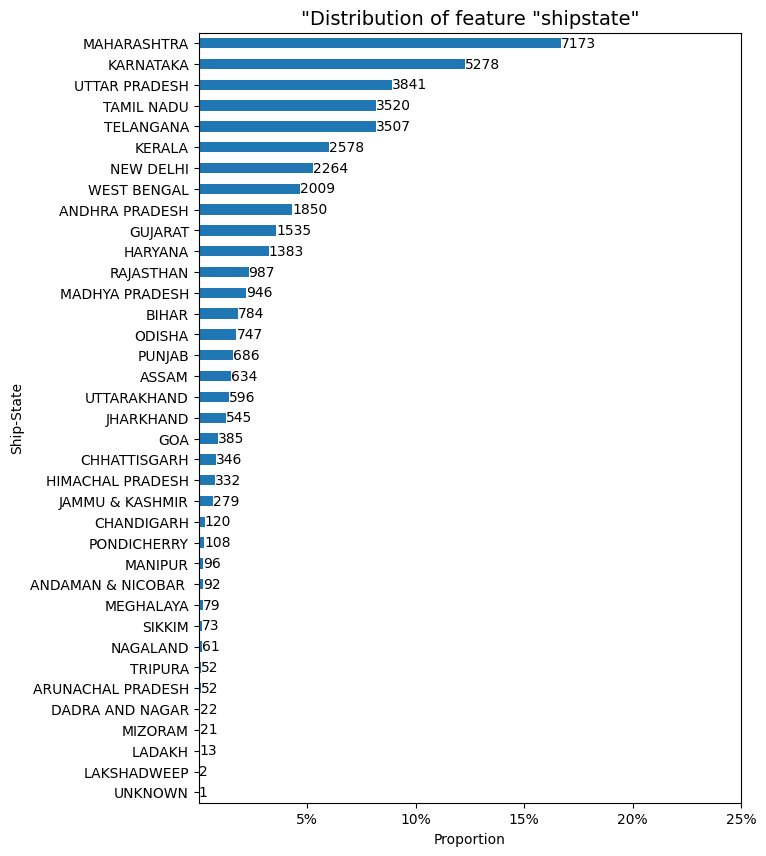

In [306]:
df_cat = df["Ship State"].value_counts().to_frame()
df_cat["proportion"] = round(df["Ship State"].value_counts(normalize = True)*100,2)
df_cat["proportion_str"] = df_cat["proportion"].astype(str).str.cat(np.full((len(df_cat),),"%"))
df_cat = (df_cat.reset_index()
          .rename(columns = {"Ship State":"count","index":"Ship State Type"}))

df_cat = df_cat.sort_values(by = "proportion").reset_index(drop = True)
fig,ax = plt.subplots(figsize = (7,10))

df_cat.plot(
    kind = "barh", x = "Ship State Type",y = "proportion",
    legend = "", ax = ax
)
plt.ylabel("Ship-State")
plt.xlabel("Proportion")
plt.title('"Distribution of feature "shipstate"', fontsize = 14)
plt.yticks(ticks = list(range(0,len(df_cat))) ,labels=df_cat["Ship State Type"],
          fontsize = 10)
plt.xticks(ticks = range(5,26,5) ,labels =["5%","10%","15%","20%","25%"])

for x,y in enumerate(df_cat["count"]):
    plt.text((df_cat["proportion"][x]),x,y,
             fontsize = 10, verticalalignment = "center")
plt.show()

**Inference:**
- The distribution is imbalanced.
- The frequency (counts) values of the North-Eastern States and Union Territories and "UNKNOWN" states are very small.

**Actions:**
- Therefore we create a feature "region" re-categorise these states to regions of Inida base on geographical Directions: "norteastindia","northindia","southindia","eastindia","westindia" and "centralindia".
- We also drop the "UNKNOWN" that has only 15 counts.

In [307]:
df["Region"] = df["Ship State"].replace({
    "MAHARASHTRA":"West India","KARNATAKA":"South India",
    'PUDUCHERRY':"South India",'TELANGANA':"South India",
    'ANDHRA PRADESH':"South India", 'HARYANA':"North India",
    'JHARKHAND':"East India", 'CHHATTISGARH':"East India",
    'ASSAM':"North East India",'ODISHA':"East India",
    'UTTAR PRADESH':"North India", 'GUJARAT':"West India",
    'TAMIL NADU':"South India", 'UTTARAKHAND':"North India",
    'WEST BENGAL':"East India", 'RAJASTHAN':"West India",
    'NEW DELHI':"Central India",'MADHYA PRADESH':"Central India",
    'KERALA':"South India", 'JAMMU & KASHMIR':"North India",
    'BIHAR':"East India",'MEGHALAYA':"North East India",
    'PUNJAB':"North India", 'GOA':"South India",
    'TRIPURA':"North East India", 'CHANDIGARH':"North India",
    'HIMACHAL PRADESH':"North India",'SIKKIM':"North East India",
    "ANDAMAN & NICOBAR ":"East India", 'MANIPUR':"North East India",
    'MIZORAM':"North East India",'NAGALAND':"North East India",
    'ARUNACHAL PRADESH':"North East India", 'LADAKH':"North India",
    'DADRA AND NAGAR':"West India",'LAKSHADWEEP':"South India",
    'PONDICHERRY': 'South India'
})

In [308]:
df = df[df["Ship State"] != "UNKNOWN"]

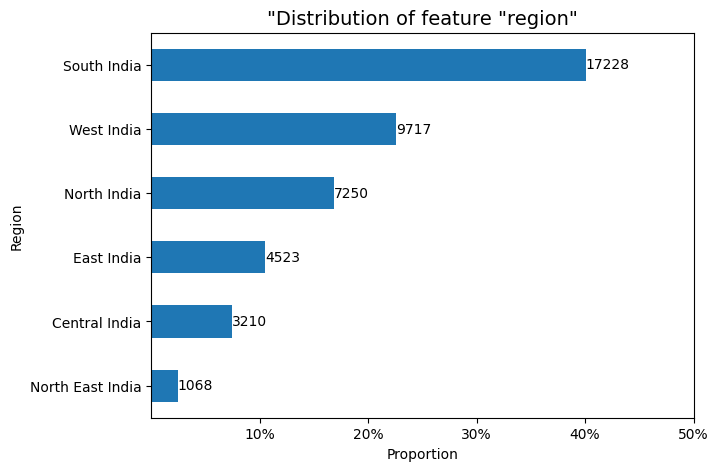

In [309]:
df_cat = df["Region"].value_counts().to_frame()
df_cat["proportion"] = round(df["Region"].value_counts(normalize = True)*100,2)
df_cat["proportion_str"] = df_cat["proportion"].astype(str).str.cat(np.full((len(df_cat),),"%"))
df_cat = (df_cat.reset_index()
          .rename(columns = {"Region":"count","index":"Region Name"}))

df_cat = df_cat.sort_values(by = "proportion").reset_index(drop = True)
fig,ax = plt.subplots(figsize = (7,5))

df_cat.plot(
    kind = "barh", x = "Region Name",y = "proportion",
    legend = "", ax = ax
)
plt.ylabel("Region")
plt.xlabel("Proportion")
plt.title('"Distribution of feature "region"', fontsize = 14)
plt.yticks(ticks = list(range(0,len(df_cat))) ,labels=df_cat["Region Name"])
plt.xticks(ticks = range(10,51,10) ,labels =["10%","20%","30%","40%","50%"])

for x,y in enumerate(df_cat["count"]):
    plt.text((df_cat["proportion"][x]),x,y,
             fontsize = 10, verticalalignment = "center")
plt.show()

**Inference:**
- The distribution is still imbalanced.
- But, regions of lower values frequency (counts) are not so small.

**Actions:**
- Drop feature "shipstate" as it will be relaced by new feature "region"

In [310]:
df.drop("Ship State",axis = "columns", inplace = True)

In [311]:
df = df.reset_index(drop = True)

## UniVarient Analysis

**UniVarient Analysys for Categorical Columns**

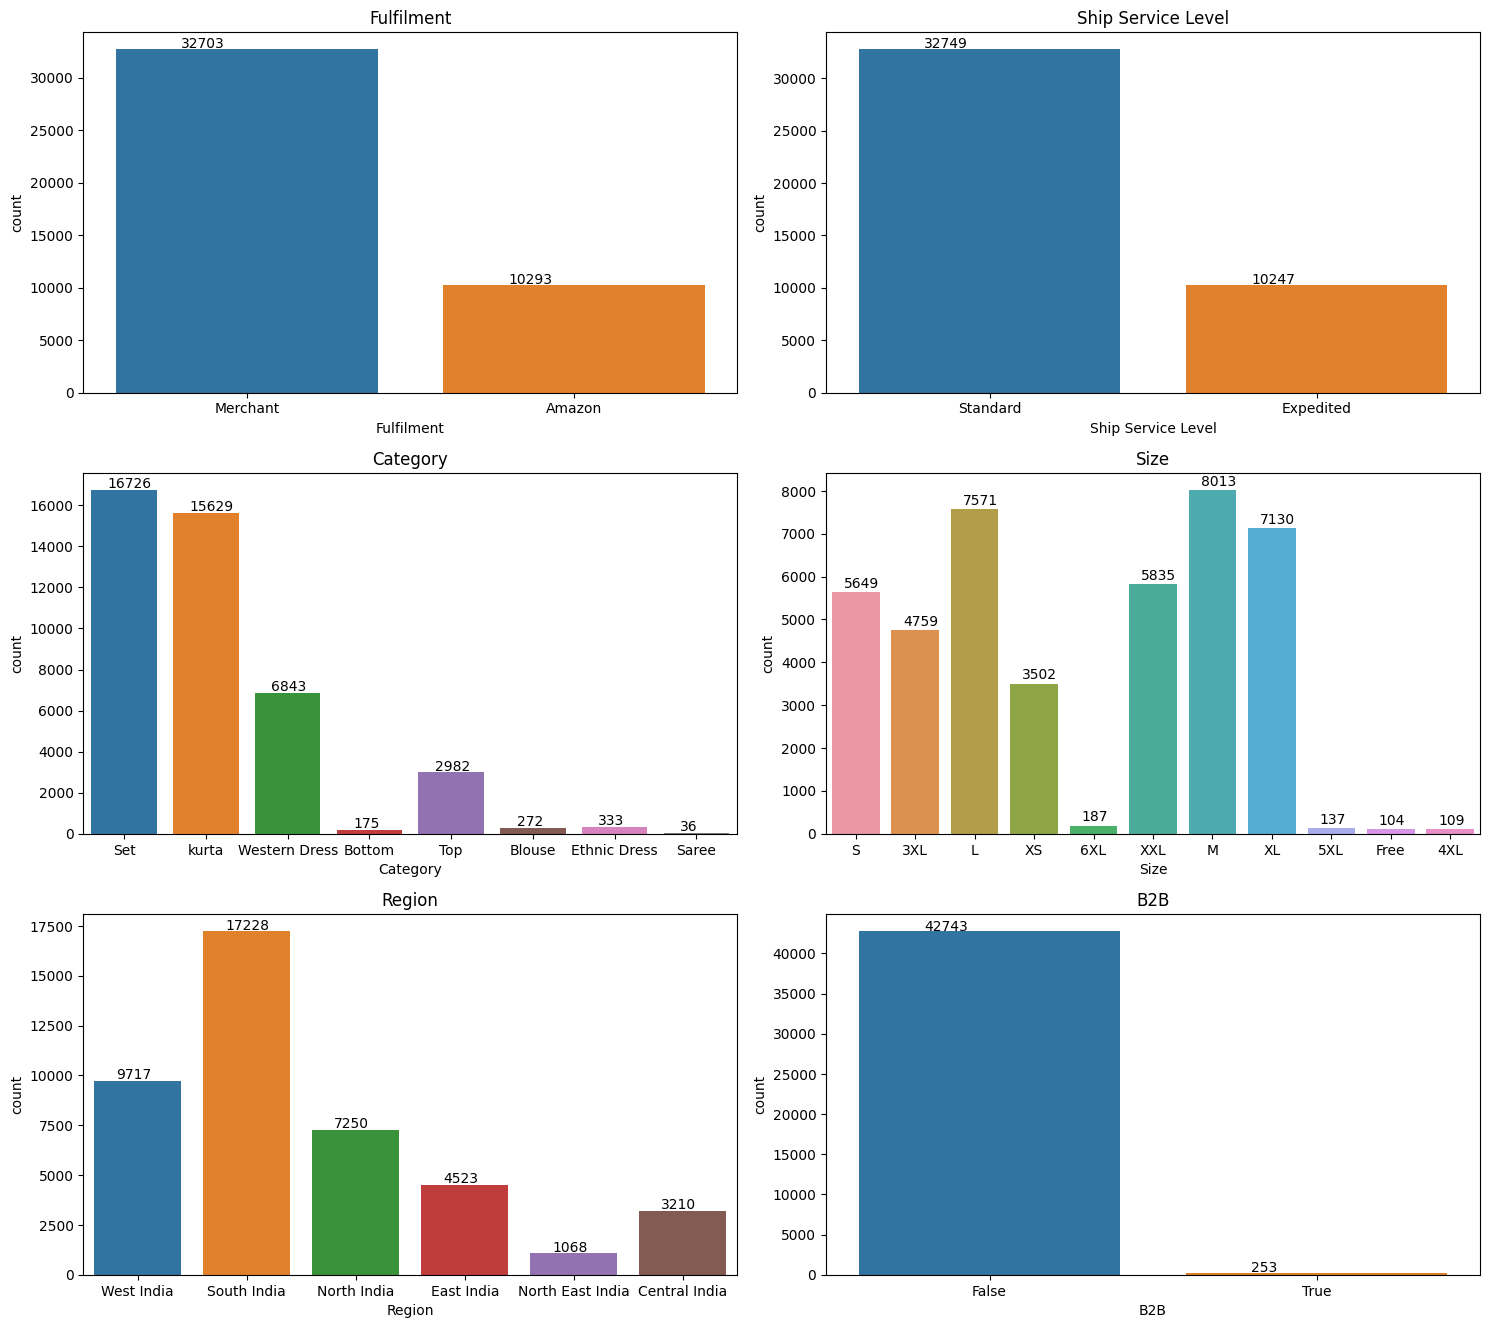

In [312]:
plot_cat_col = ['Fulfilment','Ship Service Level', 'Category', 'Size','Region','B2B']

plt.figure(figsize=(15,35))
c=1
for i in plot_cat_col:
    ax = plt.subplot(8, 2, c)
    sns.countplot(x=i,data=df)
    plt.title(i)
    plt.xticks(rotation=0)
    
    for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x() + 0.2, p.get_height() + 100))
    
    c += 1
plt.tight_layout()
plt.show()

**Inference:**
- Below, we can see that a majority of the orders are delivered by Amazon itself and a majority of the orders are processed via expedited shipping, indicating that the customers for those are either in the prime/premium category or have paid additionally for faster shipping.
- An important point can be highlighted here. Given the fact that most orders are handled by Amazon itself, and are already processed via expedited shipping, Amazon will have more flexibility and can better guarantee implementation of any changes that might be suggested via this analysis. This is valuable because such an impact would not be possible if most suggestions were to be made to third party delivery services.
- Next, visualising the ‘Category’ and ‘Size’ data points tells us that most of the orders placed have been either a set (combination of clothing types) or kurtas in particular; with a broad range of sizes being selected, all the way from small to extra-extra-large seeing robust demand.


**UniVarient Analysys for Target Column**

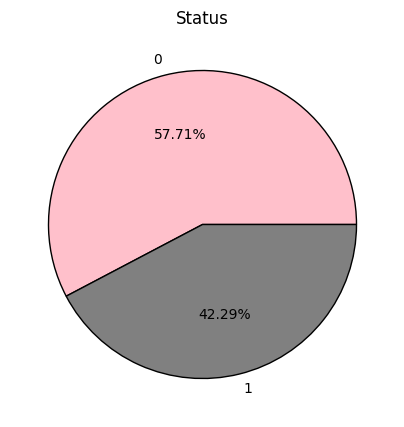

In [313]:
plt.figure(figsize=(5,5))
s=df["Status"].value_counts()
plt.pie(s.values,autopct="%.2f%%",labels=s.index,colors=['pink','gray'],wedgeprops={'edgecolor': 'black'})
plt.title('Status')
plt.show()

**Inference:**
- Most orders are categorised under the ‘Not Rejected’ section, with about 42.29% of the orders being categorised as ‘Rejected’. 

**UniVarient Analysys for Numeric Columns**

Mean: 545.539241789931
Median: 553.665
Mode: 0    0.0
Name: Amount, dtype: float64
Skewness: 0.28427054889208275
Kurtosis: 1.2917619713370163


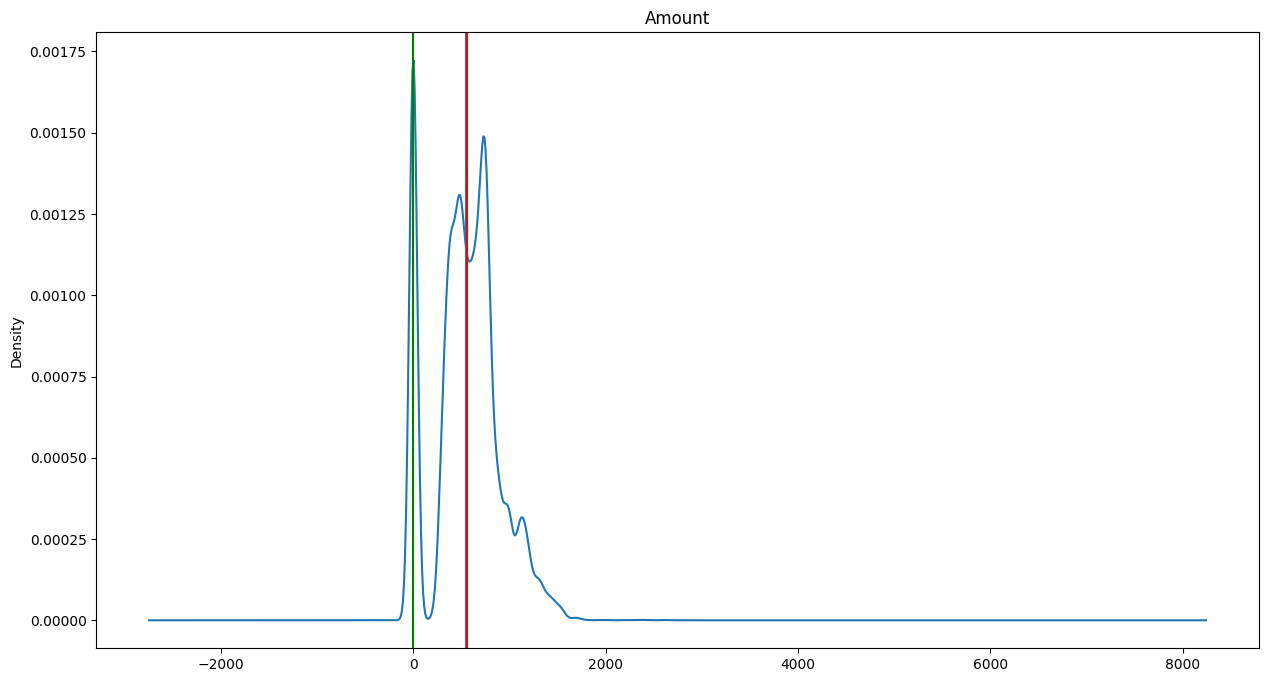

In [314]:
plot_num_col=['Amount']

for i in plot_num_col:
    df[i].plot(kind="kde")
    
    plt.axvline(df[i].mean())
    plt.axvline(df[i].median(),color="r")
    plt.axvline(df[i].mode()[0],color="green")
    
    plt.title(i)
    print("Mean:",df[i].mean())
    print("Median:",df[i].median())
    print("Mode:",df[i].mode())
    print("Skewness:",df[i].skew())
    print("Kurtosis:",df[i].kurt())
    plt.show()

**Inference:**
- Most orders contain a single unit or a single set. These orders have an average value of Rs. 545.539, with Rs. 553.665 being the most common order value. 
- Additionally, as can be seen below, a smaller segment of the orders have a much higher price value, and it might make sense to focus on them particularly to solve pain points in order processing and delivery

## BiVarient Analysys 

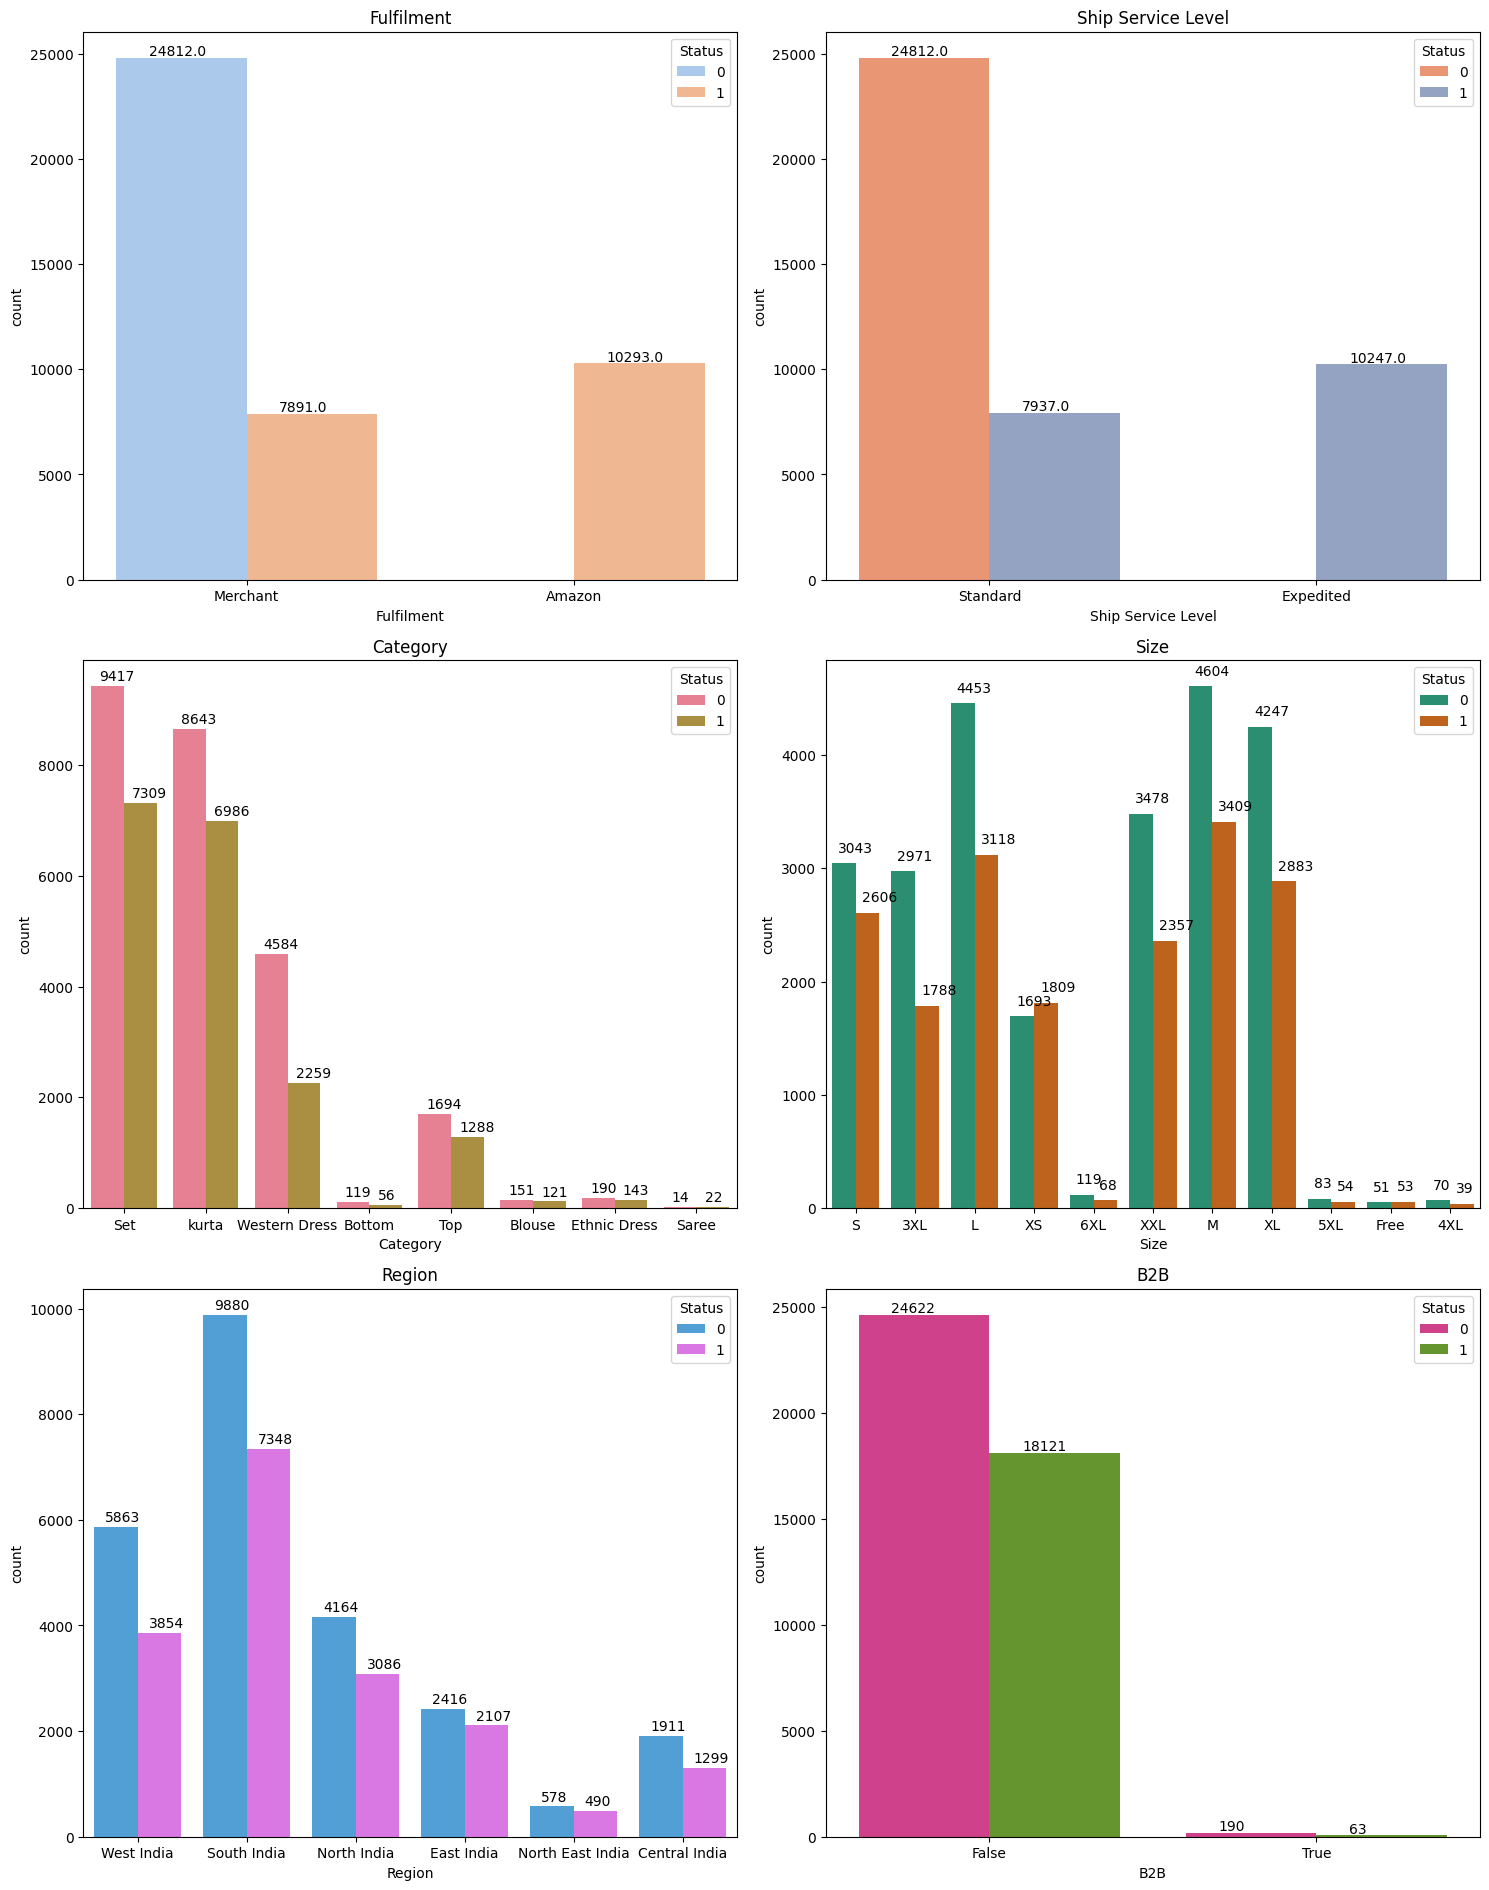

In [315]:
palette = {'Fulfilment': sns.color_palette('pastel')[0:2], 
           'Ship Service Level': sns.color_palette('Set2')[1:3], 
           'Category': sns.color_palette('husl')[0:3], 
           'Size': sns.color_palette('Dark2')[0:3],  
           'Region': sns.color_palette('husl')[4:6], 
           'B2B': sns.color_palette('Dark2')[3:5]}

plt.figure(figsize=(15,50))
c=1
for i in plot_cat_col:
    ax = plt.subplot(8, 2, c)
    sns.countplot(x=df[i],hue=df['Status'],palette=palette[i])
    plt.title(i)
    plt.xticks(rotation=0)
    
    for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x() + 0.1, p.get_height() + 100))
    
    c += 1
plt.tight_layout()
plt.show()

## MultiVarient Analysys 

In [316]:
# Total Amount by Category and Status

df.groupby(['Category','Status'])['Amount'].sum()

Category       Status
Blouse         0           75515.00
               1           44596.28
Bottom         0           41356.00
               1           13765.38
Ethnic Dress   0          131141.00
               1           61413.47
Saree          0           11821.00
               1           10237.76
Set            0         7787361.00
               1         3629176.40
Top            0          837775.00
               1          458530.77
Western Dress  0         3401470.00
               1         1141092.81
kurta          0         3906600.00
               1         1904153.37
Name: Amount, dtype: float64

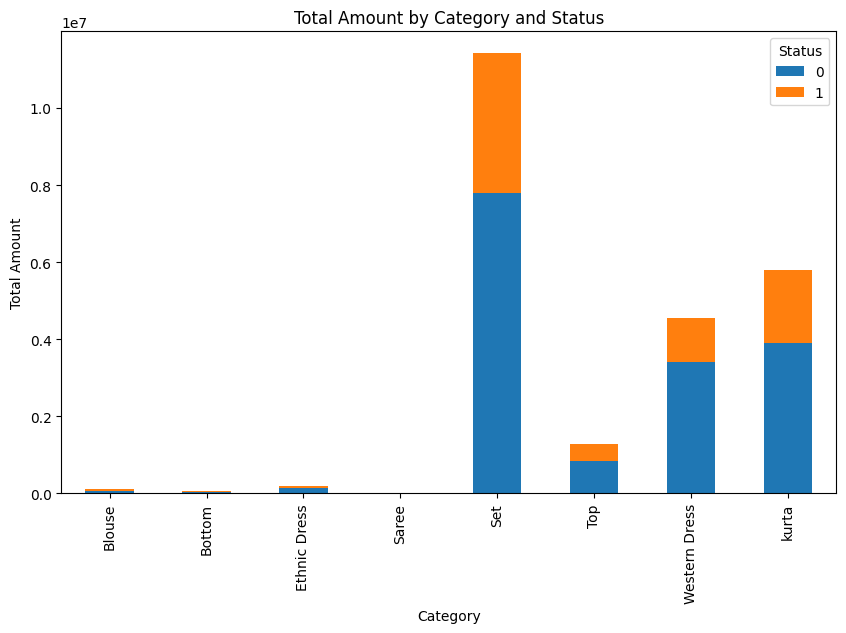

In [317]:
g1 = df.groupby(['Category', 'Status'])['Amount'].sum()

unstacked = g1.unstack()

ax = unstacked.plot(kind='bar', stacked=True, figsize=(10, 6))

ax.set_xlabel('Category')
ax.set_ylabel('Total Amount')
ax.set_title('Total Amount by Category and Status')
plt.show()

In [318]:
# Total Amount by Size and Status

df.groupby(['Size','Status'])['Amount'].sum()

Size  Status
3XL   0         1920736.00
      1          711427.32
4XL   0           54229.00
      1           17159.64
5XL   0           62676.00
      1           28618.15
6XL   0           88711.00
      1           34732.52
Free  0           27382.00
      1           19407.77
L     0         2925393.00
      1         1226776.78
M     0         3071451.00
      1         1398021.79
S     0         2050823.00
      1         1064404.16
XL    0         2690622.00
      1         1166963.81
XS    0         1147711.00
      1          698369.40
XXL   0         2153305.00
      1          897084.90
Name: Amount, dtype: float64

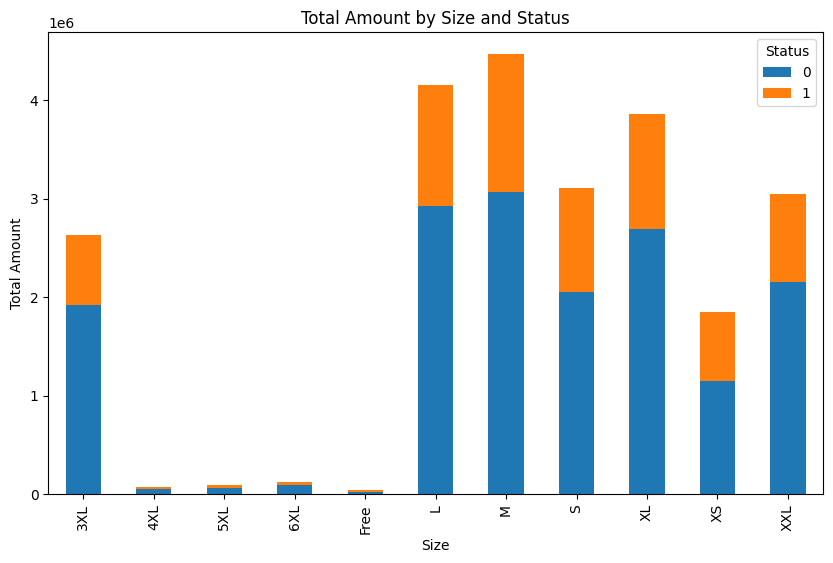

In [319]:
g2 = df.groupby(['Size', 'Status'])['Amount'].sum()

unstacked = g2.unstack()

ax = unstacked.plot(kind='bar', stacked=True, figsize=(10, 6))

ax.set_xlabel('Size')
ax.set_ylabel('Total Amount')
ax.set_title('Total Amount by Size and Status')
plt.show()

In [320]:
# Total Amount by Fulfilment and Status

df.groupby(['Fulfilment','Status'])['Amount'].sum()

Fulfilment  Status
Amazon      1          3249711.00
Merchant    0         16193039.00
            1          4013255.24
Name: Amount, dtype: float64

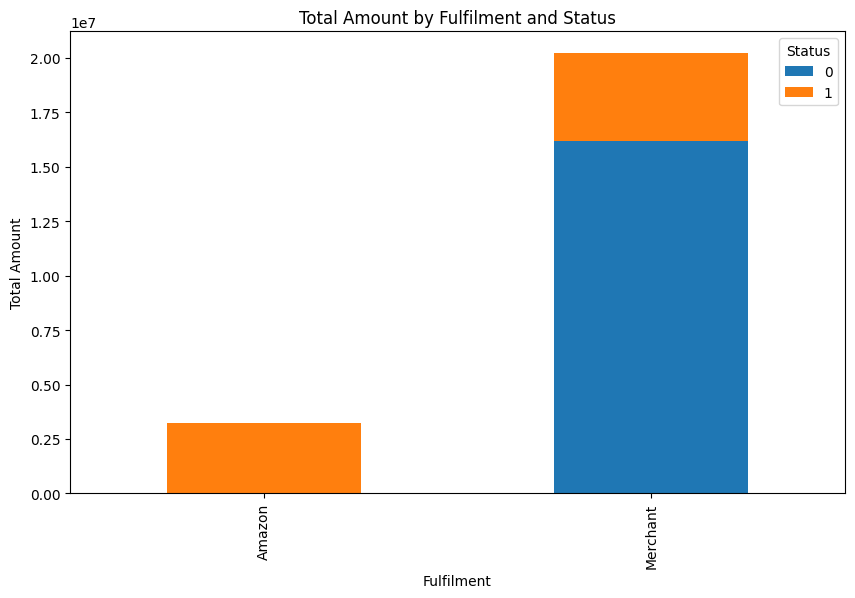

In [321]:
g4 = df.groupby(['Fulfilment', 'Status'])['Amount'].sum()

unstacked = g4.unstack()

ax = unstacked.plot(kind='bar', stacked=True, figsize=(10, 6))

ax.set_xlabel('Fulfilment')
ax.set_ylabel('Total Amount')
ax.set_title('Total Amount by Fulfilment and Status')
plt.show()

## Data Preprocessing

**Split the data into train test split**
- Split the Dataset into target and feature.
- Split the target and feature into corresponding training and test datasets for training and testing (final validation) models.

In [322]:
y = df['Status']     # target 
X = df.drop('Status', axis = "columns")   # feature 

#display target and feature
print("Target:")
display(y.head())
print("\nFeature:")
display(X.head())

Target:


0    1
1    0
2    1
3    0
4    1
Name: Status, dtype: int32


Feature:


,index,Fulfilment,Ship Service Level,Category,Size,Amount,B2B,Product Proportions,Region
0,0,Merchant,Standard,Set,S,647.62,False,Multiple Products,West India
1,1,Merchant,Standard,kurta,3XL,406.00,False,Multiple Products,South India
2,3,Merchant,Standard,Western Dress,L,753.33,False,Multiple Products,South India
3,7,Merchant,Standard,kurta,S,399.00,False,Multiple Products,South India
4,8,Amazon,Expedited,Set,3XL,0.00,False,Multiple Products,South India


In [323]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size= 0.2,random_state = 42)

print(f"Shape of X_train :{X_train.shape}\nShape of y_train: {y_train.shape}",
      f"\n\nShape of X_test: {X_test.shape}\nShape of y_test: {y_test.shape}")

Shape of X_train :(34396, 9)
Shape of y_train: (34396,) 

Shape of X_test: (8600, 9)
Shape of y_test: (8600,)


**Addressing imbalanced class dristribution.**

- i. Check for imbalance in the target class distribution in the training data
- ii. Resample the training datasets to obtain balanced target class distribution.

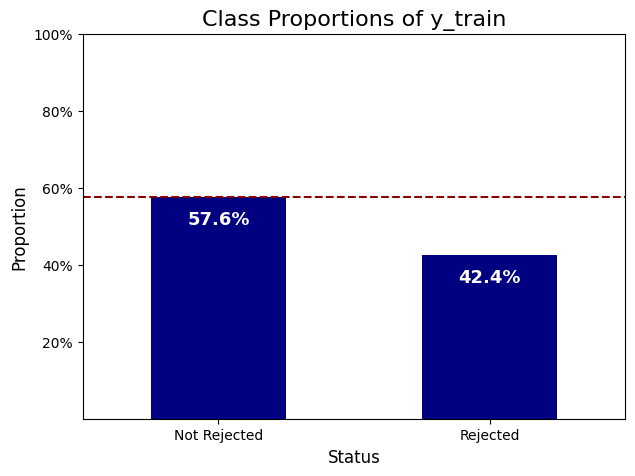

In [324]:
fig,ax = plt.subplots(figsize = (7,5))

plot_dataseries = round(y_train.value_counts(normalize = True)*100,2) 

plot_dataseries.plot(kind = "bar",ax =ax, color = "navy")
plt.axhline(y = plot_dataseries[0],color = "darkred", linestyle = "--")
plt.title("Class Proportions of y_train", fontsize = 16)
plt.ylabel("Proportion", fontsize = 12)
plt.xlabel("Status", fontsize = 12)
plt.xticks(ticks = range(len(plot_dataseries)),
           labels = ["Not Rejected", "Rejected"], rotation = "horizontal")
plt.yticks(ticks = [20,40,60,80,100], labels = ["20%","40%","60%","80%","100%"])

data_label = plot_dataseries.astype(str).str.cat(np.full((2,),"%"), sep = "")

for x,y in enumerate(plot_dataseries):
    plt.text(x,y-7,data_label[x],color = "white",
             fontweight = 700,fontsize = 13, horizontalalignment = "center")

plt.show()

**Inference:**
- It is important to balance the target variable before building the model because imbalanced datasets can lead to biased models. 
- When the target variable is imbalanced, meaning that one class is much more prevalent than the other(s), the model may learn to predict the majority class with high accuracy while ignoring the minority class. 
- This is especially problematic if the minority class is the one of interest or if the costs of misclassifying the minority class are high.

In [325]:
# resample (training dataset) using Random Over Sampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state = 42)
X_train_over,y_train_over = ros.fit_resample(X_train,y_train)


print(f"Shape of X_train_over :{X_train_over.shape}",
      f"\nShape of y_train_over: {y_train_over.shape}")

Shape of X_train_over :(39624, 9) 
Shape of y_train_over: (39624,)


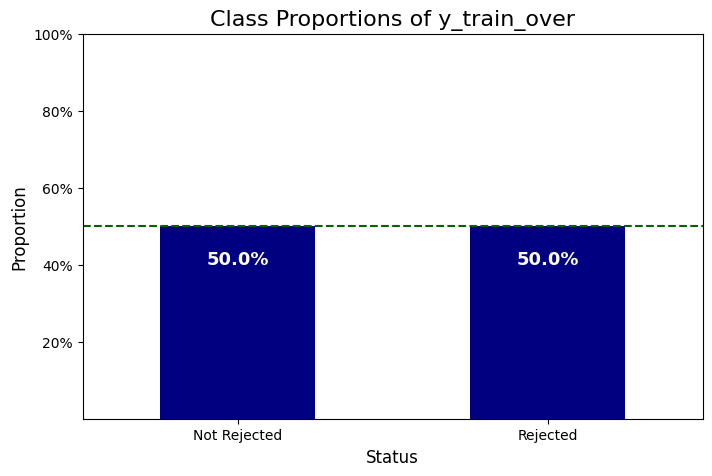

In [326]:
fig,ax = plt.subplots(figsize = (8,5))

plot_dataseries = round(y_train_over.value_counts(normalize = True)*100,2)

plot_dataseries.plot(kind = "bar",ax =ax, color = "navy")
plt.axhline(y = plot_dataseries[0],color = "darkgreen", linestyle = "--")
plt.title("Class Proportions of y_train_over", fontsize = 16)
plt.ylabel("Proportion", fontsize = 12)
plt.xlabel("Status", fontsize = 12)
plt.xticks(ticks = range(len(plot_dataseries)),
           labels = ["Not Rejected", "Rejected"], rotation = "horizontal")
plt.yticks(ticks = [20,40,60,80,100], labels = ["20%","40%","60%","80%","100%"])

data_label = plot_dataseries.astype(str).str.cat(np.full((2,),"%"), sep = "")

for x,y in enumerate(plot_dataseries):
    plt.text(x,y-10,data_label[x],color = "white",
             fontweight = 700,fontsize = 13, horizontalalignment = "center")

plt.show()

**Inference:**
- Training data is balanced.

**Encoding categorical and Scaling Numerical Data for Train Data**

In [327]:
df_cat1 = pd.get_dummies(X_train_over[['Fulfilment','Ship Service Level','Category','Region','B2B']], drop_first=True).reset_index()
df_cat1.head(3)

,index,Fulfilment_Merchant,Ship Service Level_Standard,Category_Bottom,Category_Ethnic Dress,Category_Saree,Category_Set,Category_Top,Category_Western Dress,Category_kurta,Region_East India,Region_North East India,Region_North India,Region_South India,Region_West India,B2B_True
0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0
1,1,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0
2,2,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0


In [328]:
oe = OrdinalEncoder(categories=[['XS','S','M','L','XL','XXL','3XL','4XL','5XL','6XL', 'Free']])
fitted = oe.fit_transform(X_train_over[['Size']])
size = pd.DataFrame(fitted, columns=['Size'])

In [329]:
mm=MinMaxScaler()
scaled = mm.fit_transform(X_train_over[['Amount']])
scale = pd.DataFrame(scaled, columns=['Amount'])

In [330]:
train_final = pd.concat([scale,size,df_cat1], axis=1)

In [331]:
train_final.head(3)

,Amount,Size,index,Fulfilment_Merchant,Ship Service Level_Standard,Category_Bottom,Category_Ethnic Dress,Category_Saree,Category_Set,Category_Top,Category_Western Dress,Category_kurta,Region_East India,Region_North East India,Region_North India,Region_South India,Region_West India,B2B_True
0,0.133758,0.0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0
1,0.204914,5.0,1,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0
2,0.106096,4.0,2,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0


**Encoding categorical and Scaling Numerical Data for Test Data**

In [332]:
df_cat2 = pd.get_dummies(X_test[['Fulfilment','Ship Service Level','Category','Region','B2B']], drop_first=True).reset_index()

In [333]:
size1 = pd.DataFrame(oe.transform(X_test[['Size']]), columns=['Size'])

scaled1 = mm.transform(X_test[['Amount']])
scale1 = pd.DataFrame(scaled1, columns=['Amount'])

test_final = pd.concat([scale1, size1, df_cat2], axis=1)


In [334]:
test_final.head(5)

,Amount,Size,index,Fulfilment_Merchant,Ship Service Level_Standard,Category_Bottom,Category_Ethnic Dress,Category_Saree,Category_Set,Category_Top,Category_Western Dress,Category_kurta,Region_East India,Region_North East India,Region_North India,Region_South India,Region_West India,B2B_True
0,0.115560,5.0,35762,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0
1,0.159600,5.0,16714,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0
2,0.061692,10.0,8406,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0.104511,4.0,42669,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0.155960,1.0,21393,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0


In [335]:
train_final.drop('index', axis=1, inplace=True)
test_final.drop('index', axis=1, inplace=True)

**Defining a generalized function to calculate the metric value of train and test data**

In [336]:
# train data

def get_train_report(model):
    train_pred = model.predict(train_final)
    return(classification_report(y_train, train_pred))

In [337]:
# test data

def get_test_report(model):
    test_pred = model.predict(test_final)
    return(classification_report(y_test, test_pred))

**Defining a generalized function to get Confusion Matrix, AUC-ROC Curve and Train/Test Classification Report for all Models**

In [379]:
def plot_metric(clf,x_test,y_test,model_name):
    plt.rcParams['figure.figsize']=[6,4]
    print("\nMetrics for the model: ",model_name)
    print('\nTrain Report:')
    train_report = get_train_report(clf)
    print(train_report)
    
    print('')
    print('\nTest Report:')
    test_report = get_test_report(clf)
    print(test_report)
    
    print('\nConfusion Matrix:')
    plot_confusion_matrix(clf,x_test,y_test,display_labels=[0,1])
    plt.show()
    
    print('\nROC Curve:')
    plot_roc_curve(clf,x_test,y_test)
    plt.show()
    
    print('--------------------------------------------------------------------------------------------------------------')

**Base model**

In [339]:
train_final1 = train_final.copy()
test_final1 = test_final.copy()

In [340]:
train_final1 = sm.add_constant(train_final1)
test_final1 = sm.add_constant(test_final1)

In [341]:
y_train = y_train_over.reset_index()

y_train.drop('index', axis=1, inplace=True)

In [342]:
y_test = y_test.reset_index()

y_test.drop('index', axis=1, inplace=True)

In [343]:
model = sm.Logit(y_train,train_final1).fit()
model.summary()

         Current function value: 0.412394
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Status   No. Observations:                39624
Model:                          Logit   Df Residuals:                    39606
Method:                           MLE   Df Model:                           17
Date:                Sat, 22 Apr 2023   Pseudo R-squ.:                  0.4050
Time:                        08:51:16   Log-Likelihood:                -16341.
converged:                      False   LL-Null:                       -27465.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          20.8282    174.391      0.119      0.905    -320.971     362.628
Amount                        -11.7188      0.298    -39.295      0.000     -12.303     -11.134
Size                           -0.0355      0.007     -4.770      0.000      -0.050      -0.021
Fulfilment_Merchant           -19.4623   2602.556     -0.007      0.994   -5120.378    5081.453
Ship Service Level_Standard    -0.8488   2608.392     -0.000      1.000   -5113.203    5111.505
Category_Bottom                -0.7627      0.259     -2.945      0.003      -1.270      -0.255
Category_Ethnic Dress           0.0892      0.219      0.407      0.684      -0.340       0.518
Category_Saree                  1.0268      0.481      2.136      0.033       0.085       1.969
Category_Set                    0.2564      0.157      1.634      0.102      -0.051       0.564
Category_Top                   -0.4347      0.164     -2.658      0.008      -0.755      -0.114
Category_Western Dress          0.0775      0.158      0.489      0.625      -0.233       0.388
Category_kurta                 -0.3374      0.156     -2.161      0.031      -0.643      -0.031
Region_East India               0.2788      0.063      4.396      0.000       0.155       0.403
Region_North East India         0.3729      0.093      4.007      0.000       0.190       0.555
Region_North India              0.1385      0.058      2.367      0.018       0.024       0.253
Region_South India             -0.0190      0.054     -0.354      0.723      -0.124       0.086
Region_West India              -0.0948      0.057     -1.662      0.096      -0.207       0.017
B2B_True                       -1.3214      0.273     -4.840      0.000      -1.857      -0.786
===============================================================================================

Possibly complete quasi-separation: A fraction 0.29 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [344]:
y_pred_prob = model.predict(test_final1)
y_pred = [ 0 if x < 0.5 else 1 for x in y_pred_prob]

**Summarizing all Models and checking which gives highest f1 score**

In [345]:
clfs = {"Logistic Regression":LogisticRegression(),
      "Decision Tree":DecisionTreeClassifier(),
      "Random Forest":RandomForestClassifier(),
      "KNN":KNeighborsClassifier(),
      "Navies Bayes":GaussianNB(),
       "Ada Boost":AdaBoostClassifier(),
       "Gradient Boosting":GradientBoostingClassifier(),
       "XGBoost":XGBClassifier(),
       "SVM":SVC(),
        "BaggingDT": BaggingClassifier(base_estimator=DecisionTreeClassifier()),
        "BaggingRF": BaggingClassifier(base_estimator=RandomForestClassifier()),
        "BaggingKnn": BaggingClassifier(base_estimator=KNeighborsClassifier()),
        "BaggingAda": BaggingClassifier(base_estimator=AdaBoostClassifier()),
        "BaggingGB": BaggingClassifier(base_estimator=GradientBoostingClassifier()),
        "BaggingXGB": BaggingClassifier(base_estimator=XGBClassifier()),
        "BaggingSVM": BaggingClassifier(base_estimator=SVC())
      }

models_report=pd.DataFrame(columns=['Model Name',"Accuracy","Recall","Precision","F1 Score"])

for clf,clf_name in list(zip(clfs.values(),clfs.keys())):
    clf.fit(train_final,y_train)
    y_pred=clf.predict(test_final)
    print("Fitting the model ....",clf_name)
    t=pd.Series({'Model Name':clf_name,
                 "Accuracy":accuracy_score(y_test,y_pred),
                 "Recall":recall_score(y_test,y_pred),
                 "Precision":precision_score(y_test,y_pred),
                 "F1 Score":f1_score(y_test,y_pred),
                 "ROC AUC Score = ": roc_auc_score(y_test,y_pred)
                })
    
    models_report=models_report.append(t,ignore_index=True)


models_report=models_report.sort_values(by='F1 Score',ascending=False)
models_report

Fitting the model .... Logistic Regression
Fitting the model .... Decision Tree
Fitting the model .... Random Forest
Fitting the model .... KNN
Fitting the model .... Navies Bayes
Fitting the model .... Ada Boost
Fitting the model .... Gradient Boosting
Fitting the model .... XGBoost
Fitting the model .... SVM
Fitting the model .... BaggingDT
Fitting the model .... BaggingRF
Fitting the model .... BaggingKnn
Fitting the model .... BaggingAda
Fitting the model .... BaggingGB
Fitting the model .... BaggingXGB
Fitting the model .... BaggingSVM


,Model Name,Accuracy,Recall,Precision,F1 Score,ROC AUC Score =
7,XGBoost,0.918488,0.856944,0.943137,0.897977,0.909872
14,BaggingXGB,0.918256,0.855556,0.943917,0.897567,0.909478
1,Decision Tree,0.907326,0.875278,0.900543,0.887731,0.902839
9,BaggingDT,0.907326,0.872222,0.903077,0.887382,0.902411
2,Random Forest,0.856279,0.810833,0.840242,0.825276,0.849917
10,BaggingRF,0.856395,0.794722,0.852249,0.822481,0.847761
6,Gradient Boosting,0.857209,0.710556,0.932216,0.806431,0.836678
13,BaggingGB,0.853605,0.699722,0.934001,0.800064,0.832061
11,BaggingKnn,0.832791,0.756111,0.829372,0.791049,0.822056
3,KNN,0.827558,0.756389,0.817963,0.785972,0.817594


**Inference:**
- As per above table we get maximum f1 score in XGBoost Classifier.
- We can go for hyper parameter tuning for this model and compare with this vanilla model.

## Top 5 Models Classification Report, Confusion Matrix, AUC-ROC Curve 


Metrics for the model:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Train Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.92     19812
           1       0.96      0.88      0.92     19812

    accuracy                           0.92 

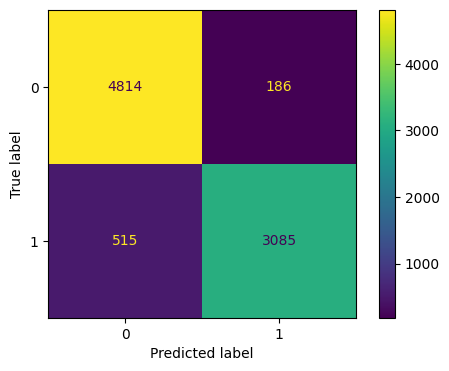


ROC Curve:


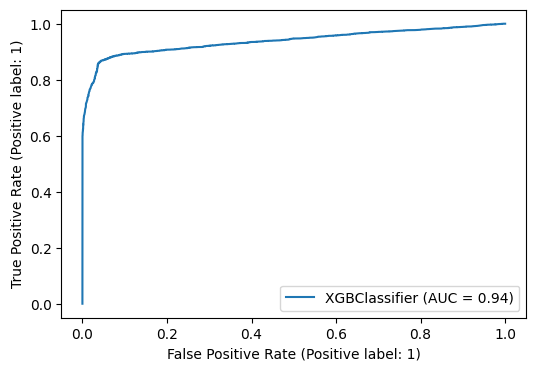

--------------------------------------------------------------------------------------------------------------

Metrics for the model:  BaggingClassifier(base_estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric=None,
                                               feature_types=None, gamma=None,
                                               gpu_id=None, grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=No

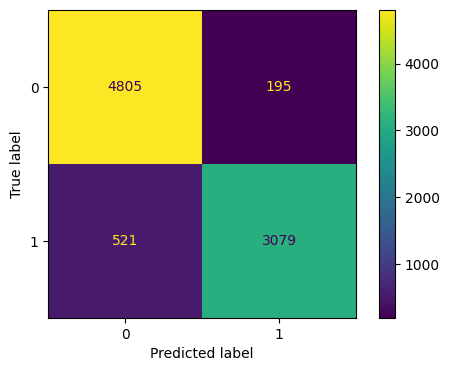


ROC Curve:


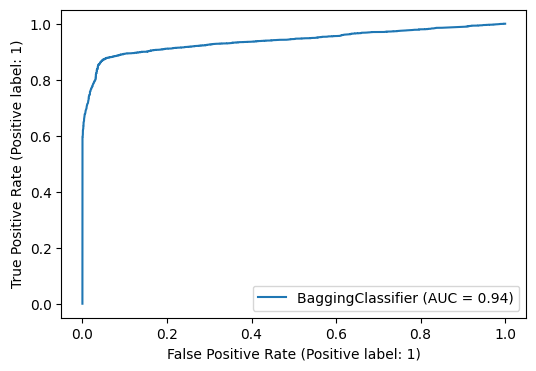

--------------------------------------------------------------------------------------------------------------

Metrics for the model:  BaggingClassifier(base_estimator=DecisionTreeClassifier())

Train Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     19812
           1       0.96      0.93      0.95     19812

    accuracy                           0.95     39624
   macro avg       0.95      0.95      0.95     39624
weighted avg       0.95      0.95      0.95     39624



Test Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      5000
           1       0.90      0.87      0.89      3600

    accuracy                           0.91      8600
   macro avg       0.90      0.90      0.90      8600
weighted avg       0.91      0.91      0.91      8600


Confusion Matrix:


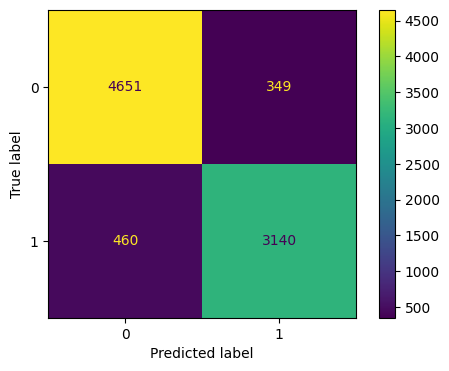


ROC Curve:


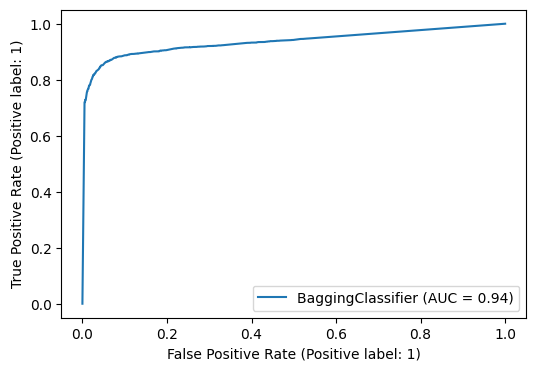

--------------------------------------------------------------------------------------------------------------

Metrics for the model:  DecisionTreeClassifier()

Train Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     19812
           1       0.97      0.93      0.95     19812

    accuracy                           0.95     39624
   macro avg       0.95      0.95      0.95     39624
weighted avg       0.95      0.95      0.95     39624



Test Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      5000
           1       0.90      0.88      0.89      3600

    accuracy                           0.91      8600
   macro avg       0.91      0.90      0.91      8600
weighted avg       0.91      0.91      0.91      8600


Confusion Matrix:


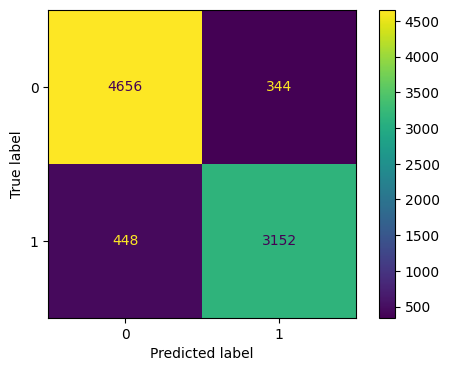


ROC Curve:


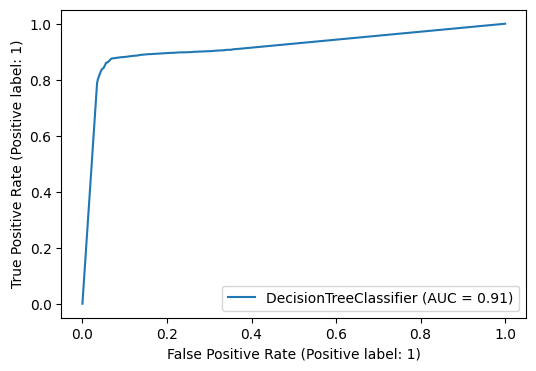

--------------------------------------------------------------------------------------------------------------

Metrics for the model:  RandomForestClassifier()

Train Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     19812
           1       0.96      0.94      0.95     19812

    accuracy                           0.95     39624
   macro avg       0.95      0.95      0.95     39624
weighted avg       0.95      0.95      0.95     39624



Test Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      5000
           1       0.84      0.81      0.82      3600

    accuracy                           0.86      8600
   macro avg       0.85      0.85      0.85      8600
weighted avg       0.86      0.86      0.86      8600


Confusion Matrix:


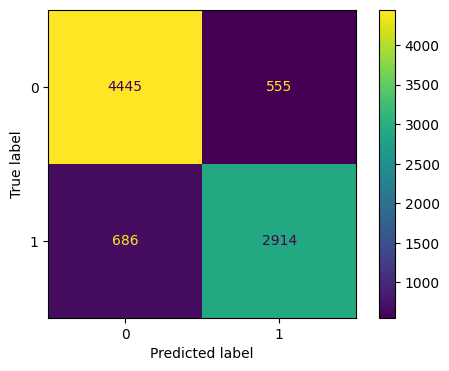


ROC Curve:


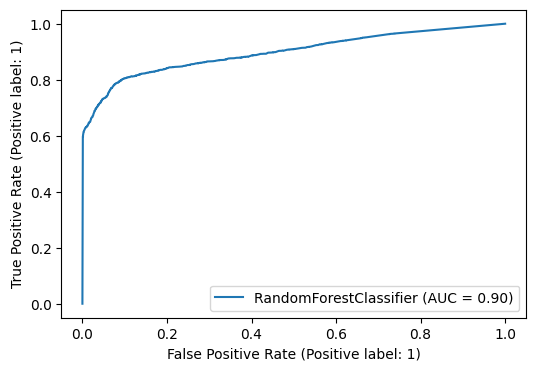

--------------------------------------------------------------------------------------------------------------


In [381]:
# Calling plot_metric function to get confusion matrix, roc-auc curve and classification report for all models.
# we'll cal it for top 10 models.

a=[XGBClassifier(),BaggingClassifier(base_estimator=XGBClassifier()),BaggingClassifier(base_estimator=DecisionTreeClassifier()),
DecisionTreeClassifier(),RandomForestClassifier()]
 
for i in a:
    i.fit(train_final,y_train)
    plot_metric(i, test_final, y_test, i)

**Finding the model which gives least error rate**

XGBClassifier : 0.09310825572479509 0.004281513159611561
BaggingClassifierXGB : 0.09299996956098688 0.0028148416525099404
BaggingClassifierDT : 0.0910257275153803 0.004419798352171417
DecisionTreeClassifier : 0.09307889891158949 0.004500309689961844
RandomForestClassifier : 0.13182075871536958 0.005193908971392192


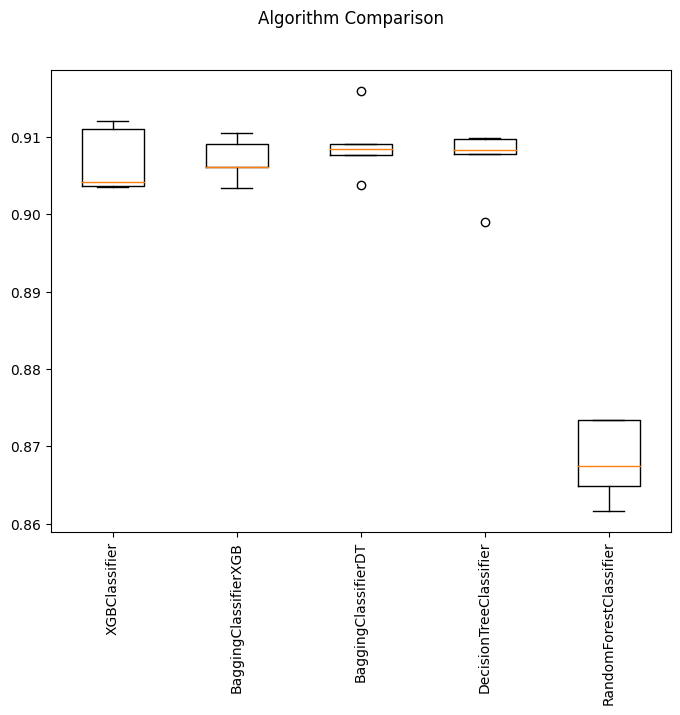

In [362]:
results = []
names = []
top5_model = {'XGBClassifier': XGBClassifier(),'BaggingClassifierXGB':BaggingClassifier(base_estimator=XGBClassifier()),
              'BaggingClassifierDT': BaggingClassifier(base_estimator=DecisionTreeClassifier()),
                'DecisionTreeClassifier':DecisionTreeClassifier(),'RandomForestClassifier':RandomForestClassifier()}
for name,model in top5_model.items():
    kf =KFold(n_splits=5, shuffle=True, random_state=42)
    cv = cross_val_score(model, train_final, y_train, cv=kf, scoring='f1')
    results.append(cv)
    names.append(name)
    print(name,':', (1-np.mean(cv)), np.std(cv, ddof=1))
plt.rcParams['figure.figsize']=[8,6]
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.xticks(rotation=90)
plt.show()

**Inference:**
- The XGBoost Classifier has the highest median f1 score.
- Higher the value of f1 score better is the performance of the model.
- It also have a smaller box and shorter whiskers indicate a more consistent performance compared to other models.
- 1-np.mean(cv) calculates the error rate for each model based on the mean F1 score obtained from cross-validation.
- By both vanilla model as well as error rate, we got to know that XGBoost Classifier is the best model compared to all other models.
- Hence we can further check for the tuned parameters for the XGBoost model and check for their performance.

### Hyperparameter Tuning for the XGBoost Classifier

## Final Model
**Fitting the XGBoost model with the parameters obtained from the hyper tuned paramter**

In [363]:
xgb_tuned_model = XGBClassifier(learning_rate = 0.2,max_depth = 7,gamma = 0,n_estimators=400,random_state=42)
xgb_model = xgb_tuned_model.fit(train_final, y_train)


Metrics for the model:  XGBoost Tuned Params

Train Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     19812
           1       0.96      0.90      0.93     19812

    accuracy                           0.93     39624
   macro avg       0.94      0.93      0.93     39624
weighted avg       0.94      0.93      0.93     39624



Test Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      5000
           1       0.94      0.87      0.91      3600

    accuracy                           0.92      8600
   macro avg       0.93      0.92      0.92      8600
weighted avg       0.92      0.92      0.92      8600


Confusion Matrix:


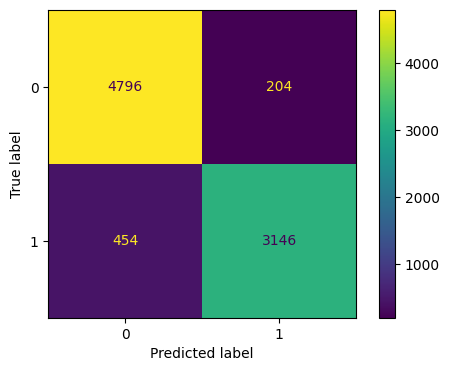


ROC Curve:


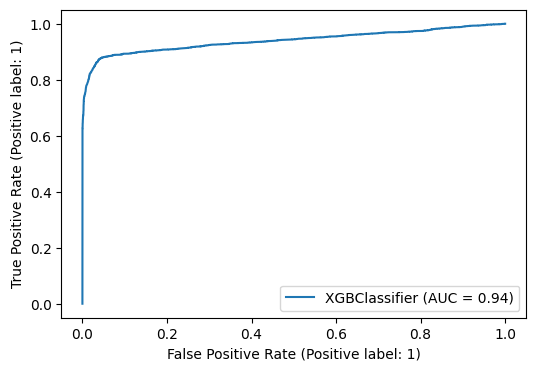

--------------------------------------------------------------------------------------------------------------


In [364]:
plot_metric(xgb_model,test_final,y_test,'XGBoost Tuned Params')

**Inference:**
- The confusion matrix of the vanilla model showed that it had a high number of false negatives, meaning that it misclassified a large number of positive instances as negative. 
- This led to a low recall score and a relatively high false negative rate. On the other hand, the hypertuned model showed a significant improvement in terms of reducing the false negative rate and improving the recall score. 
- Additionally, the hypertuned model also showed a lower false positive rate, which means that it was better at correctly identifying negative instances. 
- Overall, the hypertuned model had a better balance between precision and recall, and it performed significantly better than the vanilla model.


### Model Interpretation

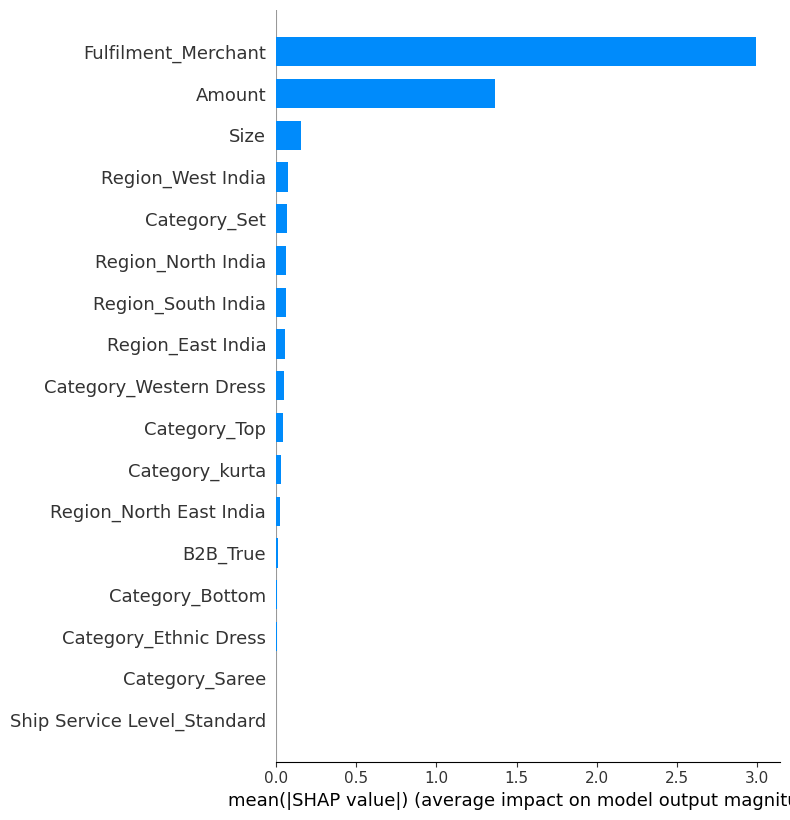

In [365]:
import shap
plt.rcParams['figure.figsize']=[8,6]
value = shap.TreeExplainer(xgb_model).shap_values(test_final)
shap.summary_plot(value,train_final,plot_type="bar",feature_names=train_final.columns)

**Inference:**
- Each bar in the plot represents a feature.The bars are sorted in descending order of the sum of the absolute SHAP values across all instances, which indicates the overall importance of each feature in the model.
- The most important features are (Fulfilment_Merchant,Amount and Size) with the highest bars. These features have the greatest impact on the predicted target variable, and should be given more attention when interpreting the model and making predictions.


## Conclusion / Insights

- After evaluating the models, we find that XGBoost has the highest accuracy, F1-score, Roc-Auc Score compared to other models.  - In addition, XGBoost is computationally efficient, simple, and aligns well with our domain knowledge as it is commonly used for classification problems. 
- Therefore, we can conclude that XGBoost is the best model for this problem.
- Also, we may conclude that the important features impacting the decision of the customer in rejecting the orders or not are Fulfilment_Merchant,Amount and Size as they are found having greater magnitude and in top five features, common, in both the models.
- The findings may be of valuable insights to business owners, sellers and other stakeholders, and the are recommended to focus on these important features.
- Some of the limitations of this analysis aree exclusion of orders with multiple-product purchase,ununconfirmed status and some features.